In [1]:
import ROOT
#from ROOT import gStyle
#from ROOT import gPad
#gStyle.SetOptStat(0)
#from ag import *
import matplotlib.pyplot as pp
import matplotlib as mpl
import numpy as nn
import os
from scipy import optimize
from scipy.stats import pearsonr
from iminuit import Minuit, cost
from scipy import stats
from math import erfc

Welcome to JupyROOT 6.30/06


In [2]:
scintillators = [107, 108, 109, 110]
fast          = True # load all events or just a small fraction

In [3]:
pattern = '_'.join(['%i' % s for s in scintillators])
folder  = 'data'
name    = 'Scint_%s_waves/FILTERED/SDataF_Scint_%s.root' % (pattern, pattern)
file    = ROOT.TFile.Open(os.path.join(folder, name))
tree    = file.Data_F

In [4]:
lsb        = 1000/1024
n_baseline = 80
n_fast     = 1000
threshold  = 1e-3
threshold_precision = 1000/1024
elim       = 4000 # there is some pileup above 4000

In [5]:
height   = []
baseline = []
energy   = []
channel  = []
n = tree.GetEntries()
for i in range(0, min(n_fast, n) if fast else n):
    tree.GetEntry(i)
    wave = nn.array(tree.Samples)
    b    = nn.mean(wave[:n_baseline])
    m    = nn.max(wave[n_baseline:])
    height.append((m-b)*lsb)
    baseline.append(b*lsb)
    energy.append(tree.Energy)
    channel.append(tree.Channel)
height   = nn.array(height)
baseline = nn.array(baseline)
energy   = nn.array(energy)
channel  = nn.array(channel)

In [6]:
def exponnorm_cdf(x, s1, K1, loc1, scale1):
    return s1 * stats.exponnorm.cdf(x, K=K1, loc=loc1, scale=scale1)
def fit(vals, bins): 
    c = cost.ExtendedBinnedNLL(vals, bins, exponnorm_cdf)
    initial_guess = {
        "s1"     : sum(vals),
        "K1"     : 5,
        "loc1"   : bins[nn.argmax(vals)],
        "scale1" : 10}
    global m
    m = Minuit(c, **initial_guess)
    m.limits["K1"]      = (0, None)
    m.limits["scale1"]  = (0, None)
    m.limits["loc1"]    = (min(bins), max(bins))
    m.limits["s1"]      = (.8*sum(vals), 1.2*sum(vals))
    m.migrad(ncall=int(1e4))
    #assert .91 < m.values.to_dict()['s1'] < 1.09
    return m.fval, m.fmin.reduced_chi2, m.values.to_dict()

In [7]:
def bincenters(bins):
    return (bins[1:] + bins[:-1]) / 2

height fit: {'s1': 285.0016006243934, 'K1': 3.659755373428284, 'loc1': 96.95499131898791, 'scale1': 16.96466301860378}
charge fit: {'s1': 299.99998670776796, 'K1': 63.87652257015128, 'loc1': 1354.177287134496, 'scale1': 33.5738897195873}


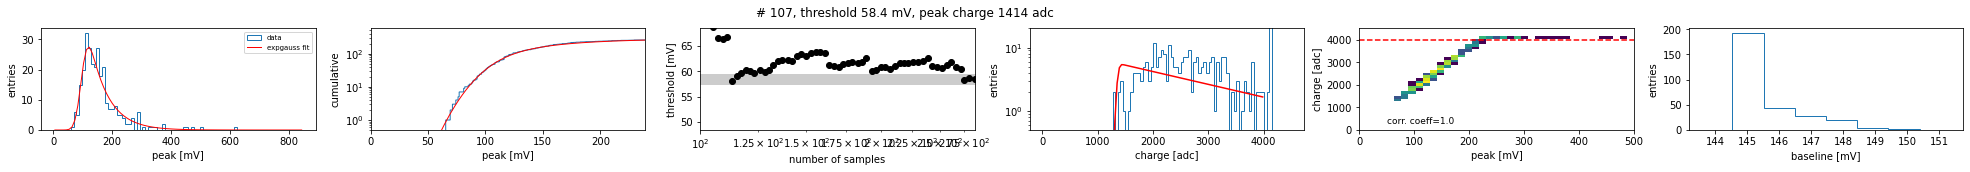

height fit: {'s1': 238.01958404493405, 'K1': 5.563638622968656, 'loc1': 79.70148229996906, 'scale1': 10.957088248297282}
charge fit: {'s1': 224.75562913793047, 'K1': 3.4375685245313488, 'loc1': 1548.0223006470505, 'scale1': 257.8523690385541}


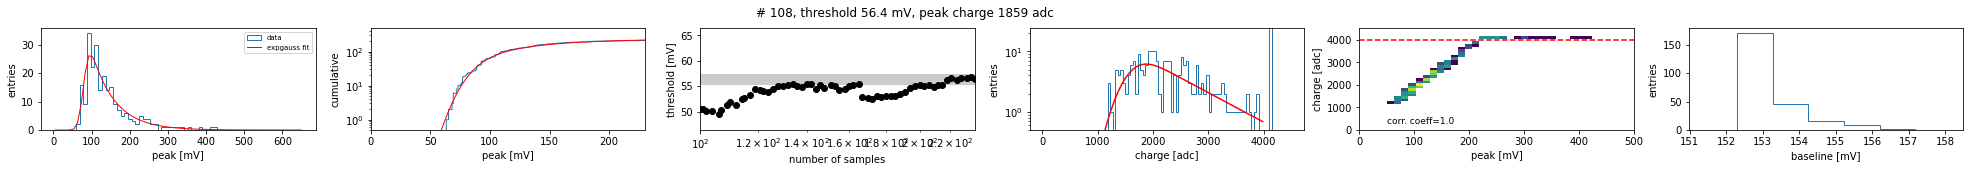

height fit: {'s1': 238.0078908375751, 'K1': 9.363207824105311, 'loc1': 88.96317248291878, 'scale1': 9.174190038527083}


In [ ]:
for c in set(channel):
    select = channel == c
    
    # height histogram
    bins   = nn.arange(0, nn.max(height[select]), lsb*10)
    fig, axs = pp.subplots(nrows=1, ncols=6, figsize=(30,2))
    vals, bins, patches = axs[0].hist(height[select], histtype='step',
        ls='solid', bins=bins, label='data')
    fval, chisq, results = fit(vals, bins)
    print('height fit:', results)
    axs[0].plot(bincenters(bins), nn.diff(exponnorm_cdf(bins, **results)), color='r', zorder=10, lw=1, label='expgauss fit')  
    axs[0].set_xlabel('peak [mV]')
    axs[0].set_ylabel('entries')
    axs[0].legend(fontsize=7)
    
    # cumulative height histogram
    finebins = nn.arange(0, nn.max(height[select]), lsb)
    finevals = exponnorm_cdf(finebins, **results)#/results['s1']
    #weights = nn.ones((nn.sum(select)))/nn.sum(select)
    axs[1].hist(height[select], histtype='step', ls='solid', cumulative=True, bins=finebins)#, weights=weights)
    threshold_voltage = optimize.bisect(
        lambda x: exponnorm_cdf(x, **results)/results['s1'] - threshold, 0, 200)
    #axs[1].text(120, 1, '%.1f mV threshold' % threshold_voltage, fontsize=8)
    axs[1].plot(finebins, finevals, color='r', zorder=10, lw=1)
    axs[1].plot([0,nn.max(height[select])], [threshold*max(finevals)]*2, ls='dashed', color='red')
    axs[1].set_xlabel('peak [mV]')
    axs[1].set_ylabel('cumulative')
    axs[1].set_xlim(0, nn.percentile(height[select], 90))
    axs[1].set_yscale('log')
    axs[1].set_ylim(.5, max(finevals)*2)
    axs[1].set_yticks(list(10**nn.arange(0, nn.log10(max(finevals)*2))))
    
    # threshold fit convergence
    h = height[select]
    lengths = [int(f) for f in nn.logspace(2, nn.log10(len(h)), 60)]
    #lengths = range(100, len(h))
    thresholds_fit = []
    thresholds_percentile = []
    for l in lengths:
        vals, bins = nn.histogram(h[:l], bins=bins)
        fval, chisq, results = fit(vals, bins)
        threshold_voltage = optimize.bisect(
            lambda x: exponnorm_cdf(x, **results)/results['s1'] - threshold, 0, 400)
        thresholds_fit.append(threshold_voltage)
        thresholds_percentile.append(nn.percentile(h[:l], threshold*100))
    #axs[2].plot(lengths, thresholds_percentile, marker='o', label='raw data')
    axs[2].scatter(lengths, thresholds_fit, marker='o', label='fitted', color='k', zorder=10)
    axs[2].set_xscale('log')
    axs[2].set_ylim(thresholds_fit[-1] - 10, thresholds_fit[-1] + 10)
    xlim = [min(lengths), max(lengths)]
    axs[2].set_xlim(*xlim)
    axs[2].fill_between(xlim, [thresholds_fit[-1] - threshold_precision]*2,[thresholds_fit[-1] + threshold_precision]*2, color='#ccc')
    #axs[2].plot(xlim, [thresholds_fit[-1] + 1]*2, color='gray', ls='dashed')
    axs[2].set_xlabel('number of samples')
    axs[2].set_ylabel('threshold [mV]')
    #axs[2].legend(fontsize=9)
    
    # charge histogram
    vals, bins, patches = axs[3].hist(energy[select], bins=nn.linspace(0, max(energy[select])*1.1, 100), histtype='step', ls='solid')
    vals, bins, patches = axs[3].hist(energy[select], bins=nn.linspace(0, elim, 100), histtype='step', alpha=0)
    fval, chisq, results = fit(vals, bins)
    print('charge fit:', results)
    y = nn.diff(exponnorm_cdf(bins, **results))
    axs[3].plot(bincenters(bins), y, color='r', zorder=10, ls='solid')
    peak_charge = bins[nn.argmax(y)]
    axs[3].set_xlabel('charge [adc]')
    axs[3].set_ylabel('entries')
    axs[3].set_yscale('log')
    axs[3].set_ylim(.5, max(vals)*2)
    #axs[3].set_xlim(0, max(bins))
    
    # charge vs height 2d histogram
    axs[4].hist2d(height[select], energy[select],
        bins=(nn.linspace(0, 500, 40),
             nn.linspace(0, nn.max(energy[select])*1.1, 40)),
        norm=mpl.colors.LogNorm())
    axs[4].set_xlabel('peak [mV]')
    axs[4].set_ylabel('charge [adc]')
    eselect = nn.logical_and(select, energy < elim)
    corr_coeff, p_value = pearsonr(height[eselect], energy[eselect])
    axs[4].text(50,300, 'corr. coeff=%.1f'%corr_coeff, ha='left', fontsize=9)
    axs[4].plot([0,nn.max(height[select])], [elim,elim], ls='dashed', color='red')
    
    # baseline histogram
    axs[5].hist(baseline[select], histtype='step', ls='solid',
        bins=nn.arange(nn.min(baseline[select])-lsb, nn.max(baseline[select])+2*lsb, lsb))
    axs[5].set_xlabel('baseline [mV]')
    axs[5].set_ylabel('entries')
    
    pp.subplots_adjust(hspace=3, top=.83, right=.99, left=0.1)
    pp.suptitle('# %i, threshold %.1f mV, peak charge %.0f adc' % (scintillators[c], threshold_voltage, peak_charge))
    pp.savefig('plot_scint_%i.pdf' % scintillators[c])
    pp.show()
    #break

In [ ]:
assert threshold == 1e-3